In [117]:
import os
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import warnings

from utils.dataset import get_df, generate_column_names

warnings.filterwarnings("ignore")

In [118]:
X_train_16, X_val_16, X_test_16, y_train_16, y_val_16, y_test_16 = get_df(window_size=16)
X_train_32, X_val_32, X_test_32, y_train_32, y_val_32, y_test_32 = get_df(window_size=32)
X_train_48, X_val_48, X_test_48, y_train_48, y_val_48, y_test_48 = get_df(window_size=48)

In [119]:
df_original = pd.read_csv("data/processed_data.csv", parse_dates=["timestamp"], index_col="timestamp")

In [141]:
PRICE_NVDA_COLS = ["nvda_close", "nvda_volume"]
PRICE_IWM_COLS = ["iwm_close", "iwm_volume"]
PRICE_GOLD_COLS = ["gold_close", "gold_volume"]
TECHNICAL_COLS = ["stoch_k"]

COLS_GROUPS = {
    "nvda": PRICE_NVDA_COLS,
    "nvda_iwm": PRICE_NVDA_COLS + PRICE_IWM_COLS,
    "nvda_gold": PRICE_NVDA_COLS + PRICE_GOLD_COLS,
    "nvda_technical": PRICE_NVDA_COLS + TECHNICAL_COLS,
    "nvda_iwm_gold": PRICE_NVDA_COLS + PRICE_IWM_COLS + PRICE_GOLD_COLS,
    "nvda_iwm_technical": PRICE_NVDA_COLS + PRICE_IWM_COLS + TECHNICAL_COLS,
    "nvda_gold_technical": PRICE_NVDA_COLS + PRICE_GOLD_COLS + TECHNICAL_COLS,
    "all_handpicked": PRICE_NVDA_COLS + PRICE_IWM_COLS + PRICE_GOLD_COLS + TECHNICAL_COLS,
    "all": df_original.drop(columns=["y"]).columns.tolist(),
}

WINDOW_SIZES_DATA_DATA = {
    16: (X_train_16, X_val_16, X_test_16, y_train_16, y_val_16, y_test_16),
    32: (X_train_32, X_val_32, X_test_32, y_train_32, y_val_32, y_test_32),
    48: (X_train_48, X_val_48, X_test_48, y_train_48, y_val_48, y_test_48),
}

MODELS = [
    "GaussianNB",
    "RandomForestClassifier",
    "XGBClassifier",
    "LGBMClassifier",
]


In [133]:
def generate_column_names_with_specific_window_size(cols_and_window_size: dict):
    column_names = []
    for col, window_size in cols_and_window_size.items():
        column_names.extend(generate_column_names([col], window_size))
    return column_names

In [134]:
generate_column_names_with_specific_window_size(
    {
        "nvda_close": 3,
        "nvda_volume": 4,
        "iwm_close": 3,
        "iwm_volume": 3,
        "gold_close": 3,
        "gold_volume": 3,
        "stoch_k": 3,
    },
)

['nvda_close_t-0',
 'nvda_close_t-1',
 'nvda_close_t-2',
 'nvda_volume_t-0',
 'nvda_volume_t-1',
 'nvda_volume_t-2',
 'nvda_volume_t-3',
 'iwm_close_t-0',
 'iwm_close_t-1',
 'iwm_close_t-2',
 'iwm_volume_t-0',
 'iwm_volume_t-1',
 'iwm_volume_t-2',
 'gold_close_t-0',
 'gold_close_t-1',
 'gold_close_t-2',
 'gold_volume_t-0',
 'gold_volume_t-1',
 'gold_volume_t-2',
 'stoch_k_t-0',
 'stoch_k_t-1',
 'stoch_k_t-2']

In [142]:
pipelines = {}
metrics_val = {}
metrics_test = {}

for window_size in WINDOW_SIZES_DATA_DATA.keys():
    X_train, X_val, X_test, y_train, y_val, y_test = WINDOW_SIZES_DATA_DATA[window_size]
    for col_group_name, col_group in COLS_GROUPS.items():
        for model_name in MODELS:
            scaler = MinMaxScaler()
            if model_name == "GaussianNB":
                model = GaussianNB()
            elif model_name == "RandomForestClassifier":
                model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            elif model_name == "XGBClassifier":
                model = XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1)
            elif model_name == "LGBMClassifier":
                params = {
                    "objective": "binary",  # For binary classification
                    "metric": "binary_logloss",  # Evaluation metric
                    "boosting_type": "gbdt",
                    "num_leaves": 31,
                    "learning_rate": 0.05,
                    "feature_fraction": 0.9,
                    "verbose": -1,  # Suppress verbose output
                }
                model = LGBMClassifier(**params, random_state=42, n_jobs=-1)
            else:
                raise ValueError(f"Unknown model name: {model_name}")
            pipeline = Pipeline([("scaler", scaler), ("classifier", model)])
            col_to_use = generate_column_names(col_group, window_size)
            X_full = pd.concat([X_train, X_val], axis=0)
            y_full = pd.concat([y_train, y_val], axis=0)
            start_time = time.time()
            pipeline.fit(X_full[col_to_use], y_full)
            end_time = time.time()
            y_pred = pipeline.predict(X_test[col_to_use])
            y_pred_proba = pipeline.predict_proba(X_test[col_to_use])[:, 1]
            train_time = end_time - start_time

            report_dict = classification_report(
                y_test,
                y_pred,
                # 0 = Down, 1 = Up
                target_names=["Down", "Up"],
                zero_division=0,
                output_dict=True,
            )
            report = classification_report(
                y_test,
                y_pred,
                # 0 = Down, 1 = Up
                target_names=["Down", "Up"],
                zero_division=0,
                output_dict=False,
            )

            fpr, tpr, _ = roc_curve(
                y_test,
                y_pred_proba,
            )
            auc_score = auc(fpr, tpr)

            pipelines[(window_size, col_group_name, model_name)] = pipeline
            metrics_test[(window_size, col_group_name, model_name)] = {
                "time_used": train_time,
                "classification_report": report_dict,
                "classification_report_str": report,
                "roc_auc": {
                    "fpr": fpr.tolist(),
                    "tpr": tpr.tolist(),
                    "auc_score": auc_score,
                },
                "col_used": col_group,
            }
            print(
                f"Completed: Window Size={window_size}, Col Group={col_group_name}, Model={model_name} in {train_time:.2f} seconds"
            )

model_dir = "4_final_experiment"
os.makedirs(model_dir, exist_ok=True)
# Save eentire pipelines and metrics dictionaries
joblib.dump(pipelines, model_dir + "/pipelines.joblib")
joblib.dump(metrics_test, model_dir + "/metrics.joblib")

Completed: Window Size=16, Col Group=nvda, Model=GaussianNB in 0.01 seconds
Completed: Window Size=16, Col Group=nvda, Model=RandomForestClassifier in 0.66 seconds
Completed: Window Size=16, Col Group=nvda, Model=XGBClassifier in 0.14 seconds
Completed: Window Size=16, Col Group=nvda, Model=LGBMClassifier in 0.10 seconds
Completed: Window Size=16, Col Group=nvda_iwm, Model=GaussianNB in 0.01 seconds
Completed: Window Size=16, Col Group=nvda_iwm, Model=RandomForestClassifier in 0.92 seconds
Completed: Window Size=16, Col Group=nvda_iwm, Model=XGBClassifier in 0.26 seconds
Completed: Window Size=16, Col Group=nvda_iwm, Model=LGBMClassifier in 0.13 seconds
Completed: Window Size=16, Col Group=nvda_gold, Model=GaussianNB in 0.01 seconds
Completed: Window Size=16, Col Group=nvda_gold, Model=RandomForestClassifier in 0.88 seconds
Completed: Window Size=16, Col Group=nvda_gold, Model=XGBClassifier in 0.28 seconds
Completed: Window Size=16, Col Group=nvda_gold, Model=LGBMClassifier in 0.15 sec

['4_final_experiment/metrics.joblib']

In [143]:
len(pipelines)

108

In [144]:
pipelines_loaded = joblib.load("4_final_experiment/pipelines.joblib")
metrics_loaded = joblib.load("4_final_experiment/metrics.joblib")

In [145]:
for window_size in WINDOW_SIZES_DATA_DATA.keys():
    for col_group_name, col_group in list(COLS_GROUPS.items()):
        for model_name in MODELS:
            print("Window Size:", window_size, "Col Group:", col_group_name, "Model:", model_name)
            print(metrics_loaded[(window_size, col_group_name, model_name)]["classification_report_str"])

Window Size: 16 Col Group: nvda Model: GaussianNB
              precision    recall  f1-score   support

        Down       0.55      0.92      0.69      1054
          Up       0.52      0.10      0.17       897

    accuracy                           0.54      1951
   macro avg       0.53      0.51      0.43      1951
weighted avg       0.54      0.54      0.45      1951

Window Size: 16 Col Group: nvda Model: RandomForestClassifier
              precision    recall  f1-score   support

        Down       0.58      0.72      0.64      1054
          Up       0.53      0.38      0.44       897

    accuracy                           0.56      1951
   macro avg       0.55      0.55      0.54      1951
weighted avg       0.56      0.56      0.55      1951

Window Size: 16 Col Group: nvda Model: XGBClassifier
              precision    recall  f1-score   support

        Down       0.57      0.65      0.61      1054
          Up       0.50      0.41      0.45       897

    accuracy     

In [146]:
1054 / (897 + 1054)

0.5402357765248591

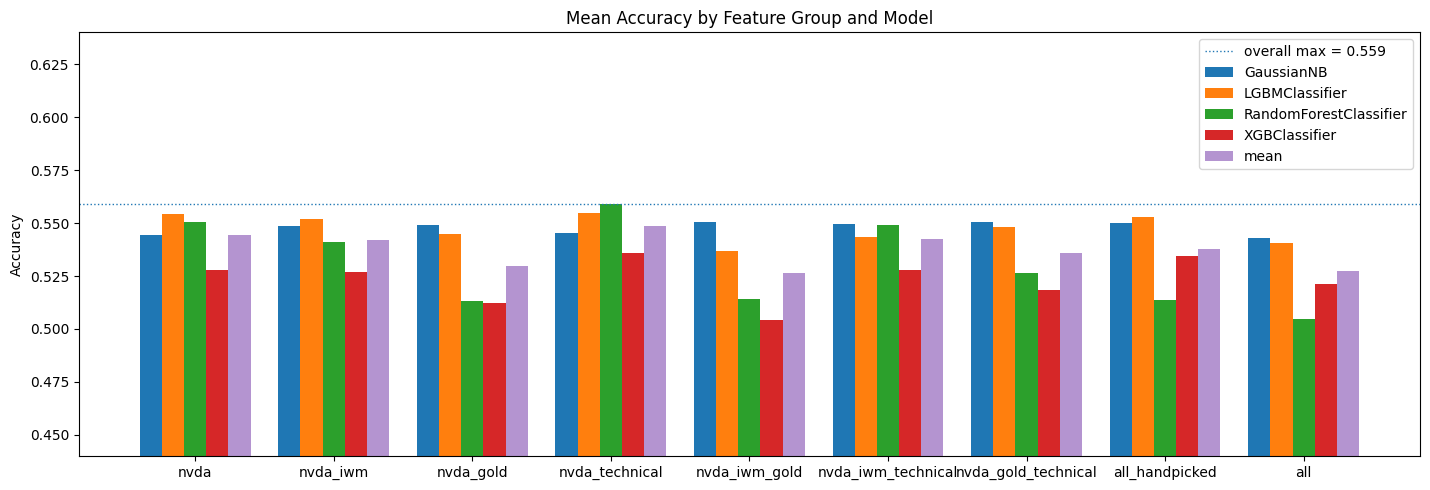

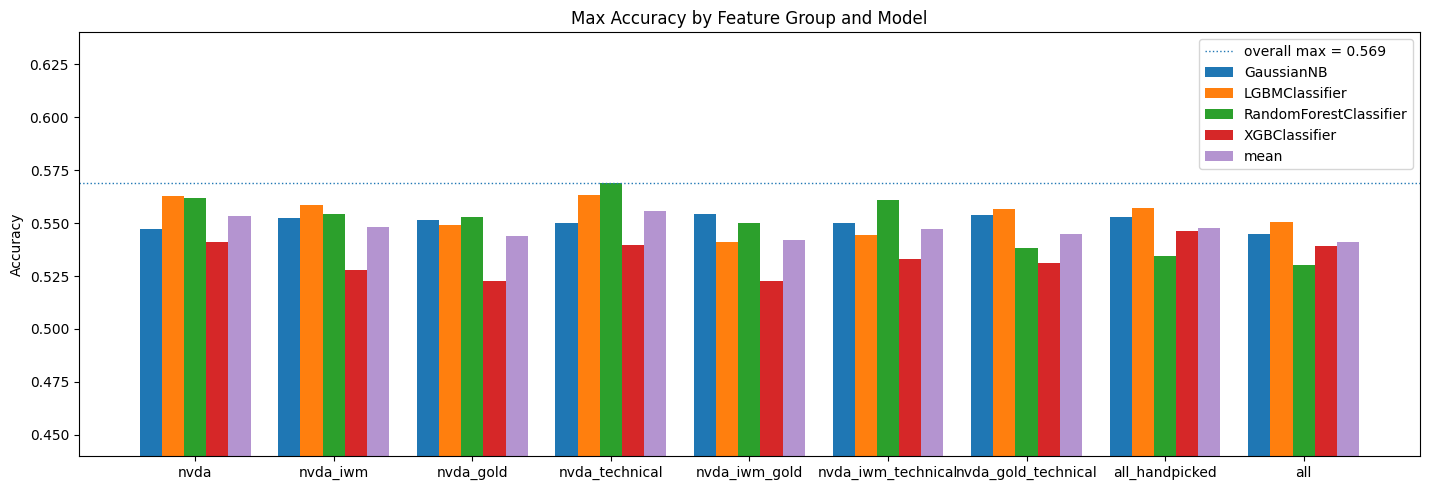

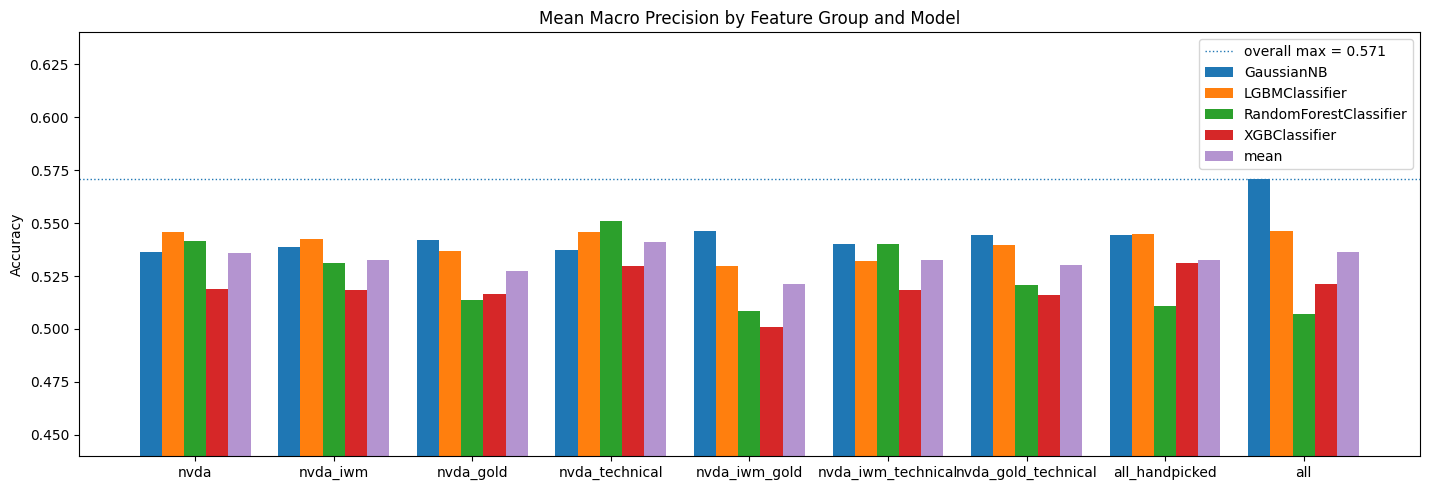

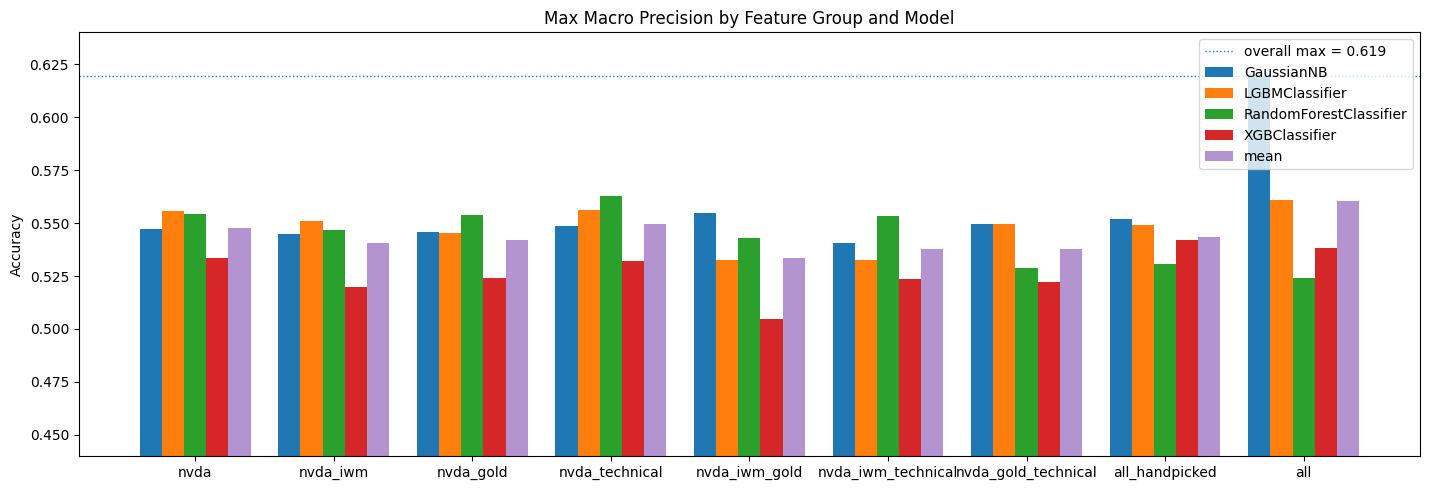

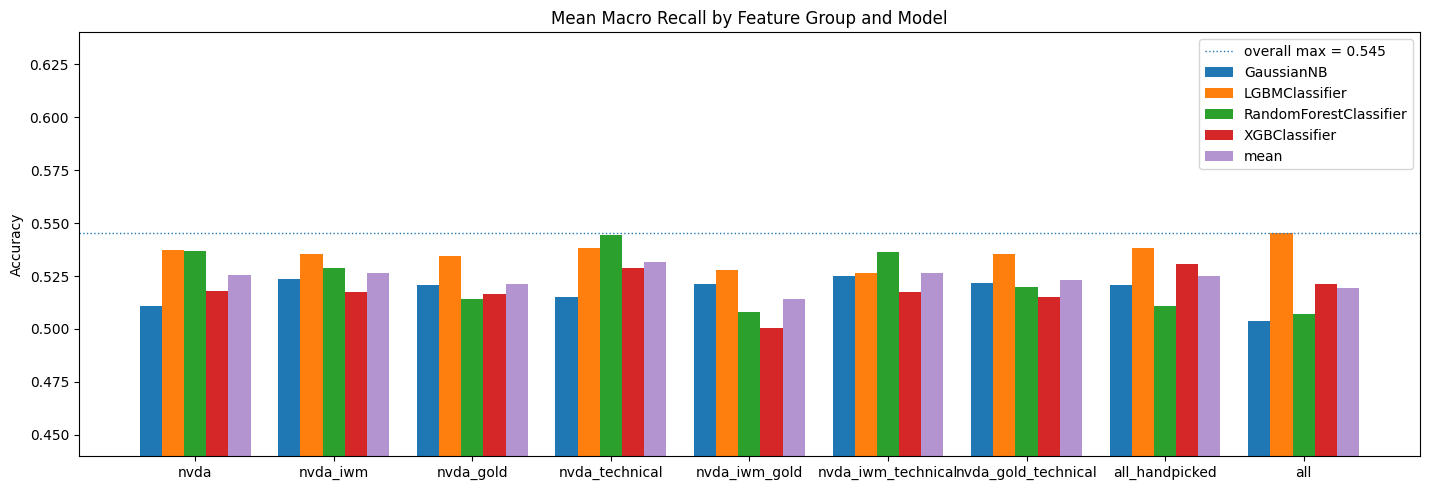

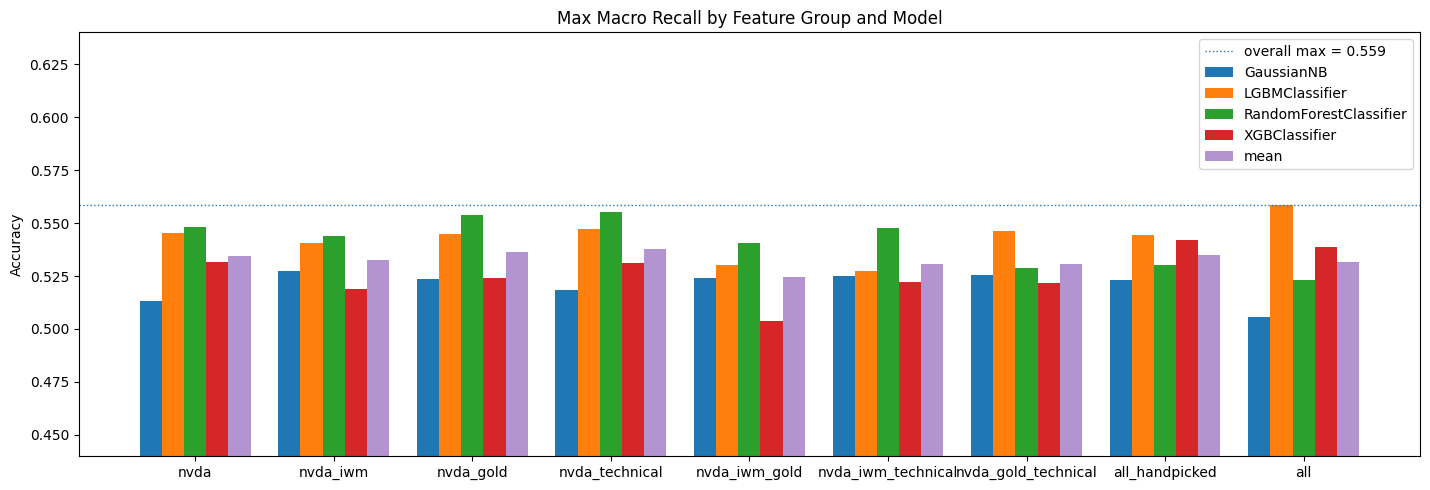

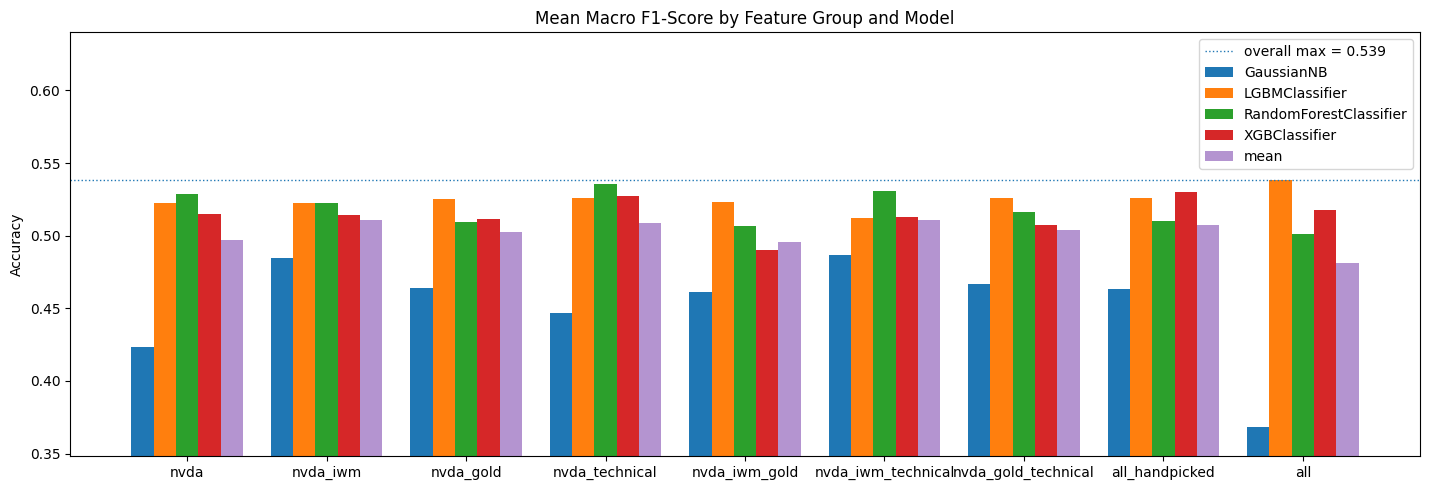

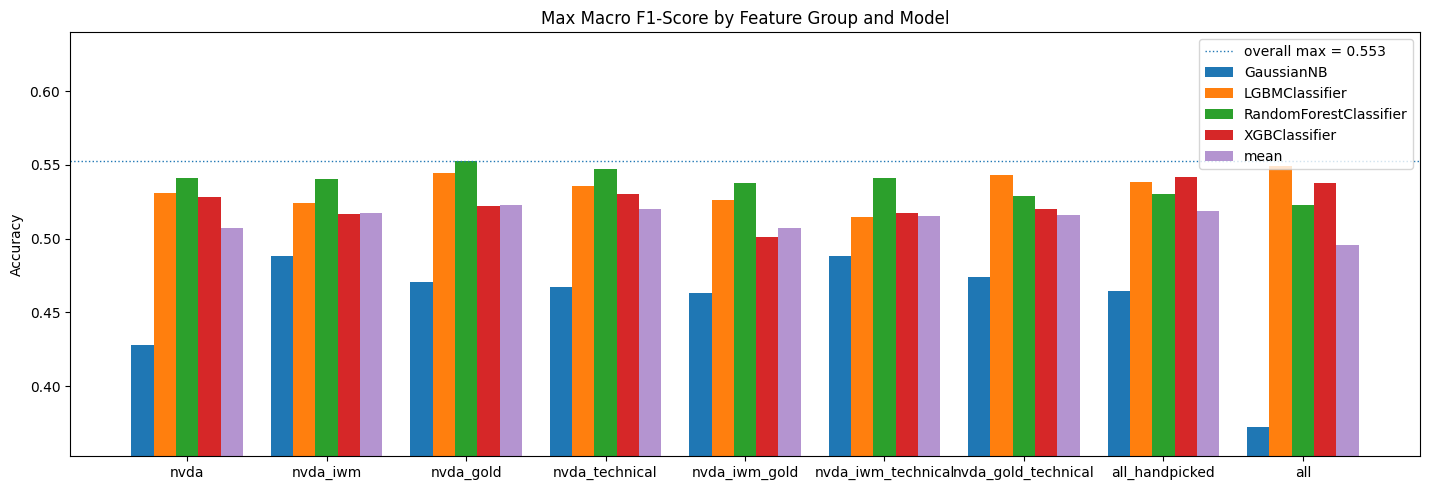

In [154]:
# Build summary DataFrame
rows = []
for window_size in WINDOW_SIZES_DATA_DATA.keys():
    for col_group_name in COLS_GROUPS.keys():
        for model_name in MODELS:
            rep = metrics_loaded[(window_size, col_group_name, model_name)]["classification_report"]
            rows.append(
                {
                    "window": window_size,
                    "col_group": col_group_name,
                    "model": model_name,
                    "accuracy": float(rep["accuracy"]),
                    "macro_precision": float(rep["macro avg"]["precision"]),
                    "macro_recall": float(rep["macro avg"]["recall"]),
                    "macro_f1": float(rep["macro avg"]["f1-score"]),
                }
            )
df = pd.DataFrame(rows)


desired_order = [
    "nvda",
    "nvda_iwm",
    "nvda_gold",
    "nvda_technical",
    "nvda_iwm_gold",
    "nvda_iwm_technical",
    "nvda_gold_technical",
    "all_handpicked",
    "all",
]

df["col_group"] = pd.Categorical(df["col_group"], categories=desired_order, ordered=True)
df = df.sort_values(["col_group", "model", "window"])


def plot_grouped_bars(matrix: pd.DataFrame, title: str, ylabel: str = "Accuracy", show_mean_bar=True):
    # reorder rows to the requested order and drop any rows not in the desired_order
    matrix = matrix.reindex(desired_order).dropna(how="all")
    groups = list(matrix.index)  # x-axis: feature groups
    models = list(matrix.columns)  # each model is a bar series
    vals = matrix.values
    n_groups, n_models = vals.shape

    # include one extra bar for group mean or max if requested
    total_bars = n_models + (1 if show_mean_bar else 0)
    x = np.arange(n_groups)
    width = 0.8 / total_bars
    center_shift = (total_bars - 1) * width / 2

    plt.figure(figsize=(max(8, 1.6 * n_groups), 5))

    # plot bars per model
    for j, model_name in enumerate(models):
        plt.bar(x + j * width - center_shift, vals[:, j], width, label=model_name)

    # plot mean across models per feature group
    if show_mean_bar:
        row_mean = np.nanmean(vals, axis=1)
        j_mean = n_models
        plt.bar(x + j_mean * width - center_shift, row_mean, width, label="mean", alpha=0.7)

    # lines for groupwise and overall maxima
    overall_max = float(np.nanmax(vals))
    overall_min = float(np.nanmin(vals))
    plt.axhline(overall_max, linestyle=":", linewidth=1, label=f"overall max = {overall_max:.3f}")

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(x, groups)

    # set sensible y-limits but keep previous defaults as minimum bounds
    lower = min(0.44, overall_min - 0.02)
    upper = max(0.64, overall_max + 0.02)
    plt.ylim(lower, upper)

    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# Compute mean accuracy by col_group and model
pivot_mean = df.pivot_table(index="col_group", columns="model", values="accuracy", aggfunc="mean").sort_index()
plot_grouped_bars(pivot_mean, title="Mean Accuracy by Feature Group and Model")

# Compute max accuracy by col_group and model
pivot_max = df.pivot_table(index="col_group", columns="model", values="accuracy", aggfunc="max").sort_index()
plot_grouped_bars(pivot_max, title="Max Accuracy by Feature Group and Model")

# Compute mean precision by col_group and model
pivot_mean = df.pivot_table(index="col_group", columns="model", values="macro_precision", aggfunc="mean").sort_index()
plot_grouped_bars(pivot_mean, title="Mean Macro Precision by Feature Group and Model")

# Compute max precision by col_group and model
pivot_max = df.pivot_table(index="col_group", columns="model", values="macro_precision", aggfunc="max").sort_index()
plot_grouped_bars(pivot_max, title="Max Macro Precision by Feature Group and Model")

# Compute mean recall by col_group and model
pivot_mean = df.pivot_table(index="col_group", columns="model", values="macro_recall", aggfunc="mean").sort_index()
plot_grouped_bars(pivot_mean, title="Mean Macro Recall by Feature Group and Model")
# Compute max recall by col_group and model
pivot_max = df.pivot_table(index="col_group", columns="model", values="macro_recall", aggfunc="max").sort_index()
plot_grouped_bars(pivot_max, title="Max Macro Recall by Feature Group and Model")

# Compute mean f1-score by col_group and model
pivot_mean = df.pivot_table(index="col_group", columns="model", values="macro_f1", aggfunc="mean").sort_index()
plot_grouped_bars(pivot_mean, title="Mean Macro F1-Score by Feature Group and Model")
# Compute max f1-score by col_group and model
pivot_max = df.pivot_table(index="col_group", columns="model", values="macro_f1", aggfunc="max").sort_index()
plot_grouped_bars(pivot_max, title="Max Macro F1-Score by Feature Group and Model")


In [155]:
y_pred = pipelines_loaded[(16, "nvda_technical", "RandomForestClassifier")].predict(
    X_test_16[generate_column_names(COLS_GROUPS["nvda_technical"], 16)]
)
confusion_matrix(y_test_16, y_pred)

array([[767, 287],
       [554, 343]])

In [173]:
best_model = pipelines_loaded[(16, "nvda_technical", "LGBMClassifier")]

In [158]:
original_df = pd.read_csv("data/processed_data.csv", parse_dates=["timestamp"], index_col="timestamp")

In [159]:
original_df.columns

Index(['nvda_open', 'nvda_high', 'nvda_low', 'nvda_close', 'nvda_volume',
       'amd_open', 'amd_high', 'amd_low', 'amd_close', 'amd_volume',
       'intc_open', 'intc_high', 'intc_low', 'intc_close', 'intc_volume',
       'spy_open', 'spy_high', 'spy_low', 'spy_close', 'spy_volume',
       'dia_open', 'dia_high', 'dia_low', 'dia_close', 'dia_volume',
       'iwm_open', 'iwm_high', 'iwm_low', 'iwm_close', 'iwm_volume',
       'insider_traded_shares_3d_shifted', 'btc_open', 'btc_high', 'btc_low',
       'btc_close', 'btc_volume', 'gold_open', 'gold_high', 'gold_low',
       'gold_close', 'gold_volume', 'overall_sentiment_score',
       'nvda_sentiment_score', 'nvda_relevance_score', 'y', 'rsi_14',
       'stoch_k', 'stoch_d', 'macd', 'macd_signal', 'macd_hist', 'sma_14',
       'atr_14', 'bb_20_upper', 'bb_20_lower', 'obv', 'obv_slope'],
      dtype='object')

In [161]:
X_test_16

,nvda_open_t-0,nvda_high_t-0,nvda_low_t-0,nvda_close_t-0,nvda_volume_t-0,amd_open_t-0,amd_high_t-0,amd_low_t-0,amd_close_t-0,amd_volume_t-0,...,stoch_d_t-15,macd_t-15,macd_signal_t-15,macd_hist_t-15,sma_14_t-15,atr_14_t-15,bb_20_upper_t-15,bb_20_lower_t-15,obv_t-15,obv_slope_t-15
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-02 09:00:00+00:00,134.6300,135.9411,134.6300,135.9211,797243.0,121.880,122.29000,121.35,122.06,51811.0,...,49.472945,0.003159,-0.075778,0.078938,137.619864,1.501008,139.937811,134.389609,1.980664e+10,-55818184.0
2025-01-02 10:00:00+00:00,135.9311,136.0810,135.5711,135.9611,206505.0,122.100,122.29000,121.89,122.17,23529.0,...,57.042134,0.048799,-0.050863,0.099662,137.893593,1.393793,140.025130,134.443200,1.980664e+10,-76349313.0
2025-01-02 11:00:00+00:00,135.9611,136.8209,135.6211,136.6309,430792.0,122.200,122.73000,121.95,122.64,42960.0,...,61.347658,0.084001,-0.023890,0.107891,137.979250,1.294237,140.105323,134.512917,1.980664e+10,-58020792.0
2025-01-02 12:00:00+00:00,136.6309,136.6909,136.1810,136.5109,778926.0,122.600,122.66000,122.11,122.29,99698.0,...,62.282337,0.110624,0.003013,0.107611,137.972779,1.298155,140.151391,134.688739,1.980664e+10,-45189715.0
2025-01-02 13:00:00+00:00,136.4909,136.7973,134.6548,136.2010,2821878.0,122.610,122.78000,120.79,122.53,378101.0,...,56.934471,0.039751,0.010360,0.029391,137.877450,1.396075,140.136659,134.785961,1.978620e+10,-43262180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30 18:00:00+00:00,157.8111,158.0161,156.8311,157.7361,14311666.0,142.345,142.43000,141.40,141.71,3589931.0,...,63.034018,0.905563,0.985463,-0.079901,156.407093,1.423441,157.899929,154.314741,1.990179e+10,60861495.0
2025-06-30 19:00:00+00:00,157.7411,158.6510,157.6611,157.8611,26770205.0,141.720,142.24000,141.22,141.89,6328950.0,...,57.222525,0.907501,0.969871,-0.062370,156.561729,1.568552,158.069844,154.344316,1.981238e+10,-28374290.0
2025-06-30 20:00:00+00:00,157.8611,158.6600,155.9600,157.7811,72869000.0,141.890,144.01955,141.01,141.70,7108561.0,...,60.540870,0.890302,0.953957,-0.063655,156.706721,1.703298,158.203822,154.353828,1.980513e+10,-36236653.0


In [163]:
COLS_GROUPS["nvda_technical"]

['nvda_close', 'nvda_volume', 'stoch_k']

In [ ]:
generate_column_names(["nvda_close", "nvda_volume", "stoch_k"], 16)

In [166]:
X_test_16[generate_column_names(COLS_GROUPS["nvda_technical"], 16)]

,nvda_close_t-0,nvda_volume_t-0,stoch_k_t-0,nvda_close_t-1,nvda_volume_t-1,stoch_k_t-1,nvda_close_t-2,nvda_volume_t-2,stoch_k_t-2,nvda_close_t-3,...,stoch_k_t-12,nvda_close_t-13,nvda_volume_t-13,stoch_k_t-13,nvda_close_t-14,nvda_volume_t-14,stoch_k_t-14,nvda_close_t-15,nvda_volume_t-15,stoch_k_t-15
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-02 09:00:00+00:00,135.9211,797243.0,22.592767,134.2613,205702.0,10.134434,134.1814,159358.0,10.764151,134.3364,...,59.453182,138.0700,408072.0,62.282337,138.0700,134107.0,65.111493,138.0700,119750.0,56.649143
2025-01-02 10:00:00+00:00,135.9611,206505.0,36.584119,135.9211,797243.0,22.592767,134.2613,205702.0,10.134434,134.1814,...,49.067893,138.0700,1186574.0,59.453182,138.0700,408072.0,62.282337,138.0700,134107.0,65.111493
2025-01-02 11:00:00+00:00,136.6309,430792.0,55.213050,135.9611,206505.0,36.584119,135.9211,797243.0,22.592767,134.2613,...,38.906656,136.9359,20431588.0,49.067893,138.0700,1186574.0,59.453182,138.0700,408072.0,62.282337
2025-01-02 12:00:00+00:00,136.5109,778926.0,61.508297,136.6309,430792.0,55.213050,135.9611,206505.0,36.584119,135.9211,...,25.718466,136.5449,23297061.0,38.906656,136.9359,20431588.0,49.067893,138.0700,1186574.0,59.453182
2025-01-02 13:00:00+00:00,136.2010,2821878.0,71.178965,136.5109,778926.0,61.508297,136.6309,430792.0,55.213050,135.9611,...,21.170307,135.6961,19427723.0,25.718466,136.5449,23297061.0,38.906656,136.9359,20431588.0,49.067893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30 18:00:00+00:00,157.7361,14311666.0,74.995658,157.8211,11223421.0,78.226725,157.9811,15288317.0,74.271105,158.0710,...,64.179636,157.3711,7256807.0,66.598303,157.4761,89412011.0,57.607000,157.7311,35371867.0,57.417306
2025-06-30 19:00:00+00:00,157.8611,26770205.0,72.165016,157.7361,14311666.0,74.995658,157.8211,11223421.0,78.226725,157.9811,...,64.721659,157.5511,4240402.0,64.179636,157.3711,7256807.0,66.598303,157.4761,89412011.0,57.607000
2025-06-30 20:00:00+00:00,157.7811,72869000.0,69.890375,157.8611,26770205.0,72.165016,157.7361,14311666.0,74.995658,157.8211,...,77.156778,157.5512,290486.0,64.721659,157.5511,4240402.0,64.179636,157.3711,7256807.0,66.598303


In [167]:
from utils.dataset import flatten_windowed_data

flatten_windowed_data(df_original[["nvda_close", "nvda_volume", "stoch_k"]], 16)


,nvda_close_t-0,nvda_volume_t-0,stoch_k_t-0,nvda_close_t-1,nvda_volume_t-1,stoch_k_t-1,nvda_close_t-2,nvda_volume_t-2,stoch_k_t-2,nvda_close_t-3,...,stoch_k_t-12,nvda_close_t-13,nvda_volume_t-13,stoch_k_t-13,nvda_close_t-14,nvda_volume_t-14,stoch_k_t-14,nvda_close_t-15,nvda_volume_t-15,stoch_k_t-15
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-04 00:00:00+00:00,23.4690,1065750.0,19.055065,23.7289,94800.0,27.884417,23.6990,132890.0,25.749036,23.6960,...,59.804748,23.9596,50490.0,56.812660,23.9596,9530.0,58.235596,23.9735,46180.0,58.092946
2022-03-04 09:00:00+00:00,23.2308,192780.0,10.677450,23.4690,1065750.0,19.055065,23.7289,94800.0,27.884417,23.6990,...,70.100361,24.0574,166470.0,59.804748,23.9596,50490.0,56.812660,23.9596,9530.0,58.235596
2022-03-04 10:00:00+00:00,23.2907,26040.0,2.928884,23.2308,192780.0,10.677450,23.4690,1065750.0,19.055065,23.7289,...,62.788852,24.2680,776990.0,70.100361,24.0574,166470.0,59.804748,23.9596,50490.0,56.812660
2022-03-04 11:00:00+00:00,23.2837,99220.0,5.521369,23.2907,26040.0,2.928884,23.2308,192780.0,10.677450,23.4690,...,40.682065,24.0364,32272410.0,62.788852,24.2680,776990.0,70.100361,24.0574,166470.0,59.804748
2022-03-04 12:00:00+00:00,23.2008,637530.0,10.052336,23.2837,99220.0,5.521369,23.2907,26040.0,2.928884,23.2308,...,27.693046,23.5023,48024650.0,40.682065,24.0364,32272410.0,62.788852,24.2680,776990.0,70.100361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30 18:00:00+00:00,157.7361,14311666.0,74.995658,157.8211,11223421.0,78.226725,157.9811,15288317.0,74.271105,158.0710,...,64.179636,157.3711,7256807.0,66.598303,157.4761,89412011.0,57.607000,157.7311,35371867.0,57.417306
2025-06-30 19:00:00+00:00,157.8611,26770205.0,72.165016,157.7361,14311666.0,74.995658,157.8211,11223421.0,78.226725,157.9811,...,64.721659,157.5511,4240402.0,64.179636,157.3711,7256807.0,66.598303,157.4761,89412011.0,57.607000
2025-06-30 20:00:00+00:00,157.7811,72869000.0,69.890375,157.8611,26770205.0,72.165016,157.7361,14311666.0,74.995658,157.8211,...,77.156778,157.5512,290486.0,64.721659,157.5511,4240402.0,64.179636,157.3711,7256807.0,66.598303


In [174]:
best_model.predict(flatten_windowed_data(df_original[["nvda_close", "nvda_volume", "stoch_k"]], 16))

array([0, 0, 0, ..., 0, 0, 0], shape=(13310,))

In [175]:
joblib.dump(best_model, "4_final_experiment/best_model_lgbm_nvda_technical_16.joblib")

['4_final_experiment/best_model_lgbm_nvda_technical_16.joblib']

In [176]:
loaded_model = joblib.load("4_final_experiment/best_model_lgbm_nvda_technical_16.joblib")

In [178]:
loaded_model.predict(flatten_windowed_data(df_original[["nvda_close", "nvda_volume", "stoch_k"]], 16))

array([0, 0, 0, ..., 0, 0, 0], shape=(13310,))